In [1]:
### Import Necessary Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Black76 with Greeks
# https://www.glynholton.com/notes/black_1976/


In [2]:
### Load in Commodities Data
def import_commod_data(tickers, start_date, end_date):
    data = pd.DataFrame()
    for t in tickers:
        data[t] = yf.download(t, start=start_date, end = end_date)['Adj Close']
    # Drop rows with NaN values
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    # Reset the index
    data.reset_index(inplace = True)
    
    return data


In [3]:
### Function to Get Most Recent Stock Price (S_0) and Set Strike (K)
def set_price_and_strike(commod_list, start_date, end_date, option_type):
    # Function Call to get FX Data
    commod_data = import_commod_data(commod_list, start_date, end_date)
    # Get the Futures Price (Most recent rate value)
    F_0 = commod_data[commod_list].iloc[-1]  # Extract the last value from the pair column
    # Set Strike Price 5% above (call) or 5% below (put) S_0
    if option_type == 'call':
        K = 1.05*F_0
    elif option_type == 'put':
        K = 0.95*F_0

    return commod_data, F_0, K

# Function Call
commod_list = ['SIL=F']
start_date = '2023-07-01'
end_date = '2024-07-01'
commod_data, F_0, K = set_price_and_strike(commod_list, start_date, end_date, option_type = 'call')
print(commod_data.tail())
print('The Most Recent Price is:', round(F_0, 4))
print('The pre-determined Strike Price is:', round(K, 4))


[*********************100%%**********************]  1 of 1 completed

          Date      SIL=F
245 2024-06-24  29.489000
246 2024-06-25  28.837000
247 2024-06-26  28.909000
248 2024-06-27  28.917999
249 2024-06-28  29.237000
The Most Recent Price is: SIL=F    29.237
Name: 249, dtype: float64
The pre-determined Strike Price is: SIL=F    30.6988
Name: 249, dtype: float64


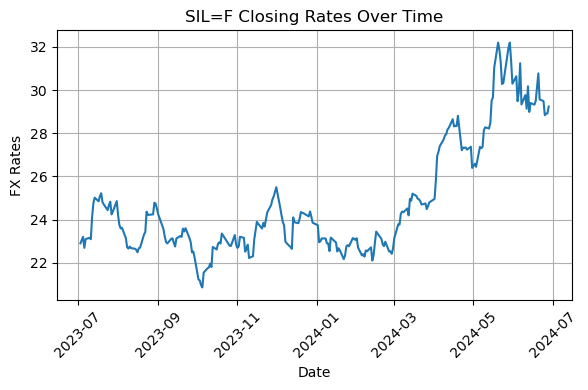

In [4]:
### Plot FX Rate Data
def plot_commod(df, commod_list):
    # Create Loop to Plot Each Individual FX Pair
    for commod in commod_list:
        plt.figure(figsize = (6, 4))

        plt.plot(df['Date'], df[commod]) # Need to adjust to spit out multiple graphs for each ticker
        plt.title(commod + ' Closing Rates Over Time')
        plt.xlabel('Date')
        plt.ylabel('FX Rates')

        plt.xticks(rotation = 45) # Rotate x-axis labels for better readability
        plt.grid(True)
        plt.tight_layout()

    return plt.show()

plot_commod(commod_data, commod_list)


In [5]:
### Function to Compute Daily Returns
def daily_returns(commod_data):
    # Drop Date Column
    commod_data = commod_data.drop(columns = ['Date'])

    # Compute the daily returns of the forex data
    rets = commod_data.pct_change().dropna()

    return rets

returns = daily_returns(commod_data)
print(returns.tail())


        SIL=F
245 -0.002840
246 -0.022110
247  0.002497
248  0.000311
249  0.011031


In [6]:
### Function to compute sigma (std dev of log normal historical stock return data)
def compute_sigma(rets):
    sigma = np.std(rets) * np.sqrt(252)
    return sigma

sigma = compute_sigma(returns)
print(sigma)


SIL=F    0.287497
dtype: float64


In [7]:
### Function to Create Black76 Model
def black76(option_type, r, F_0, K, T, sigma):
    # Define Values as Floats
    F_0 = float(F_0)
    K = float(K)
    T = float(T)
    sigma = float(sigma)
    # Calculate d_1 and d_2
    d_1 = (np.log(F_0 / K) + 0.5 * sigma ** 2 * T) / (sigma * np.sqrt(T))
    d_2 = d_1 - sigma * np.sqrt(T)
    # Calculate the option value
    if option_type == 'call':
        option_value = np.exp(-r * T) * (F_0 * norm.cdf(d_1) - K * norm.cdf(d_2))
    elif option_type == 'put':
        option_value = np.exp(-r * T) * (K * norm.cdf(-d_2) - F_0 * norm.cdf(-d_1))

    return option_value, d_1, d_2

# Function Call to Calculate Option Premium
r = 0.1
T = 1
option_value, d_1, d_2 = black76('call', r, F_0, K, T, sigma)
print('The calculated call option premium is:', round(option_value.item(), 4))
print('The calculated d_1 is:', round(d_1.item(), 4))
print('The calculated d_2 is:', round(d_2.item(), 4))


The calculated call option premium is: 2.4822
The calculated d_1 is: -0.026
The calculated d_2 is: -0.3135


In [8]:
### Calculate Black76 Greeks
def b76_greeks(d_1, d_2, F_0, K, T, r, sigma):
    delta = norm.cdf(d_1)
    gamma = norm.pdf(d_1) / (F_0 * sigma * np.sqrt(T))
    theta = -((F_0 * norm.pdf(d_1) * sigma) / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * norm.cdf(d_2)
    vega = F_0 * norm.pdf(d_1) * np.sqrt(T)
    rho = K * T * np.exp(-r * T) * norm.cdf(d_2)
    
    return delta, gamma, theta, vega, rho

delta, gamma, theta, vega, rho = b76_greeks(d_1, d_2, F_0, K, T, r, sigma)
print('The calculated delta is:', round(delta.item(), 4))
print('The calculated gamma is:', round(gamma.item(), 4))


The calculated delta is: 0.4896
The calculated gamma is: 0.0474


In [9]:
### Function to Calculate Dynamic Hedge Positions
def dyn_hedge_positions(F0, K, T, r, sigma, commod_data, option_type):
    positions = []
    deltas = []
    gammas = []

    # Initial calculation
    option_value, d_1, d_2 = black76(option_type, r, F0, K, T, sigma)
    initial_delta, initial_gamma, _, _, _ = b76_greeks(d_1, d_2, F0, K, T, r, sigma)

    # Set the initial position based on the delta
    if option_type == 'call':
        position = initial_delta
    elif option_type == 'put':
        position = -initial_delta

    # Loop through the data and calculate the positions
    for i in range(len(commod_data)):
        '''
        By iterating over commod_data, we update F to the current price of the underlying asset at each time step, 
        allowing us to recalculate the Greeks and adjust the hedge positions accordingly.
        '''
        F = commod_data.iloc[i] if isinstance(commod_data, pd.Series) else commod_data[i] # Get each futures value in the rows of the commodity data
        F = float(F)  # Ensure F is a float
        remaining_T = T - i / 252  # Assuming 252 trading days in a year
        option_value, d_1, d_2 = black76(option_type, r, F, K, remaining_T, sigma)
        delta, gamma, _, _, _ = b76_greeks(d_1, d_2, F, K, remaining_T, r, sigma)

        # Adjust the hedge position over time
        '''
        Hedge Ratio Values: The positions list contains the hedge ratio values. Each value indicates how much of 
                            the underlying asset should be held or shorted to hedge the position.
        Neg Delta Values: These values are the negative of the delta values calculated for the option at each time step. 
                          A negative delta indicates a short position, while a positive delta would indicate a long position.   
        '''
        positions.append(-delta)
        deltas.append(delta)
        gammas.append(gamma)

    return positions, deltas, gammas

### Call Function to Calculate Hedge Positions
positions, deltas, gammas = dyn_hedge_positions(F_0, K, T, r, sigma, commod_data['SIL=F'], 'call')
print("Positions:", positions[:5])
print("Deltas:", deltas[:5])
print("Gammas:", gammas[:5])


Positions: [-0.19043155423220898, -0.20239333721042402, -0.18058751223628827, -0.19670079370415122, -0.19855001528991506]
Deltas: [0.19043155423220898, 0.20239333721042402, 0.18058751223628827, 0.19670079370415122, 0.19855001528991506]
Gammas: [SIL=F    0.041283
dtype: float64, SIL=F    0.042364
dtype: float64, SIL=F    0.040475
dtype: float64, SIL=F    0.042
dtype: float64, SIL=F    0.042215
dtype: float64]


In [10]:
### Function to Perform Backtesting of Dynamic Hedge
def backtest_dyn_hedge(F0, K, T, r, sigma, option_type, commod_data):
    daily_rets = daily_returns(commod_data)
    positions, deltas, gammas = dyn_hedge_positions(F0, K, T, r, sigma, commod_data.squeeze(), option_type)
    long_pos = 1000  # Fixed long position of 1000 commodity units
    short_pos = []
    long_rets = []
    short_rets = []

    # Loop over the data and backtest the dynamic hedge
    for i in range(len(daily_rets)):
        # Calculate the short position at each step (measured in commodity units)
        short_pos_val = long_pos * positions[i]
        short_pos.append(short_pos_val)

        # Calculate Daily Returns for the Long/Short Positions
        long_ret = daily_rets.iloc[i] * long_pos
        short_ret = daily_rets.iloc[i] * short_pos_val
        long_rets.append(long_ret)
        short_rets.append(short_ret)

    # Convert lists to pandas Series for cumulative return calculations
    long_rets = pd.Series(long_rets)
    short_rets = pd.Series(short_rets)

    # Calculate the hedge returns
    hedged_rets = long_rets - short_rets

    # Compute cumulative returns for the hedged and unhedged positions
    hedged_cumulative_rets = (1 + hedged_rets / long_pos).cumprod() * (long_pos + abs(pd.Series(short_pos)))
    unhedged_cumulative_rets = (1 + daily_rets.squeeze()).cumprod() * long_pos

    return short_pos, hedged_cumulative_rets, unhedged_cumulative_rets

### Call Function to Backtest Dynamic Hedge
short_pos, hedged_cumulative_rets, unhedged_cumulative_rets = backtest_dyn_hedge(F_0, K, T, r, sigma, 'call', commod_data['SIL=F'])
print("Last 5 Short Positions:", short_pos[-5:])
print("Last 5 Hedged Cumulative Returns:", hedged_cumulative_rets[-5:])
print("Last 5 Unhedged Cumulative Returns:", unhedged_cumulative_rets[-5:])


Last 5 Short Positions: [-240.78117864005205, -207.48721043085794, -82.54176125450424, -71.71426109486919, -51.36317638386297]
Last 5 Hedged Cumulative Returns: 244    1498.933960
245    1419.768991
246    1276.297967
247    1263.954054
248    1254.333192
dtype: float64
Last 5 Unhedged Cumulative Returns: 245    1287.954247
246    1259.477638
247    1262.622314
248    1263.015347
249    1276.947922
Name: SIL=F, dtype: float64


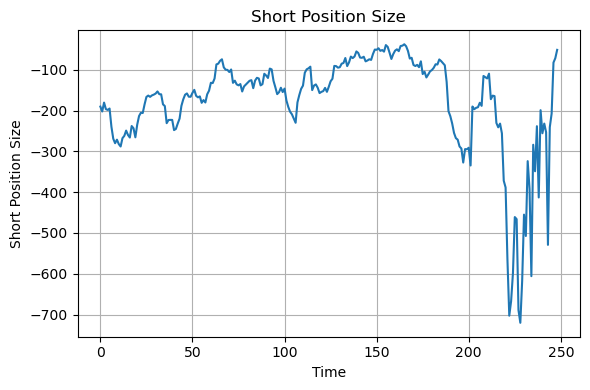

In [11]:
### Plot Short Position Size Over Time
def plot_short_pos(short_pos):
    plt.figure(figsize = (6, 4))
    plt.plot(short_pos)
    plt.title('Short Position Size')
    plt.xlabel('Time')
    plt.ylabel('Short Position Size')
    plt.grid(True)
    plt.tight_layout()
    return plt.show()

plot_short_pos(short_pos)


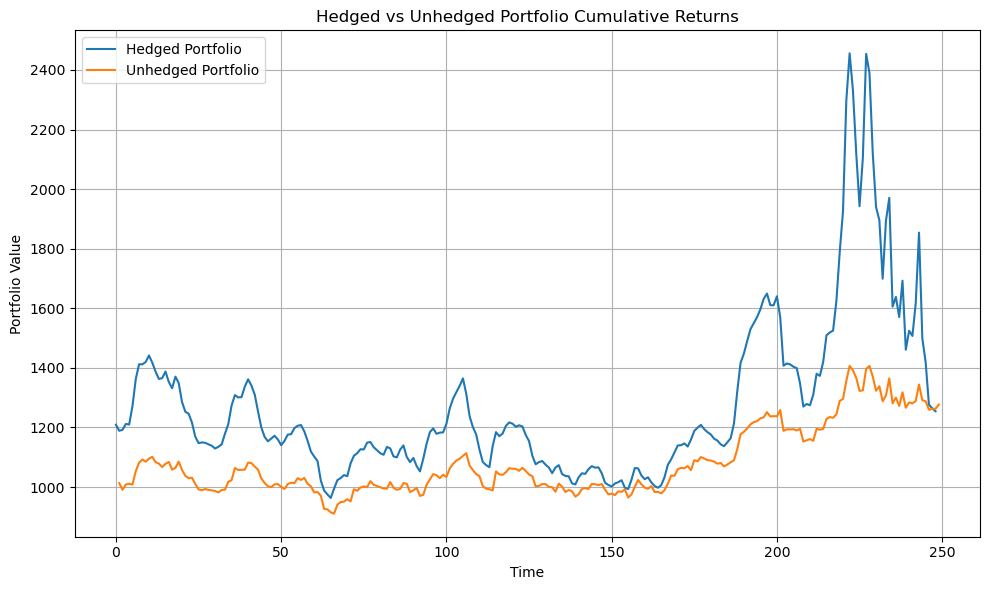

In [12]:
### Plot Cumulative Returns
def plot_cumulative_returns(hedged_cumulative_rets, unhedged_cumulative_rets):
    plt.figure(figsize = (10, 6))
    plt.plot(hedged_cumulative_rets, label = 'Hedged Portfolio')
    plt.plot(unhedged_cumulative_rets, label = 'Unhedged Portfolio')
    plt.title('Hedged vs Unhedged Portfolio Cumulative Returns')
    plt.xlabel('Time')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    return plt.show()

plot_cumulative_returns(hedged_cumulative_rets, unhedged_cumulative_rets)


In [13]:
### Compute Performance Metrics
def performance_metrics(long_pos, short_pos, hedged_cumulative_rets, unhedged_cumulative_rets, returns):
    # Calculate Total Invested Capital
    total_invs_hedged = long_pos + abs(short_pos[-1]) 
    total_invs_unhedged = long_pos
    
    # Calculate Total Percentage Return ((Current - Start / Start) * 100)
    hedged_total_rets = ((hedged_cumulative_rets.iloc[-1] - total_invs_hedged) / total_invs_hedged) * 100
    unhedged_total_rets = ((unhedged_cumulative_rets.iloc[-1] - total_invs_unhedged) / total_invs_unhedged) * 100
    
    # Calculate Annualized Return (Total Return / Number of Years) as a percentage
    hedged_ann_rets = ((hedged_cumulative_rets.iloc[-1] / total_invs_hedged)**(252 / len(returns)) - 1) * 100
    unhedged_ann_rets = ((unhedged_cumulative_rets.iloc[-1] / total_invs_unhedged)**(252 / len(returns)) - 1) * 100
    
    # Calculate Mean Returns (annualized)
    hedged_mean = np.mean(hedged_cumulative_rets.pct_change().dropna()) * 252 * 100
    unhedged_mean = np.mean(unhedged_cumulative_rets.pct_change().dropna()) * 252 * 100
    
    # Calculate Standard Deviation
    hedged_stddev = np.std(hedged_cumulative_rets.pct_change().dropna()) * np.sqrt(252)
    unhedged_stddev = np.std(unhedged_cumulative_rets.pct_change().dropna()) * np.sqrt(252)
    
    # Calculate Sharpe Ratio (Mean Return / Std Dev)
    hedged_sharpe_ratio = (hedged_mean / 100) / hedged_stddev # Divide by 100 to convert to decimal
    unhedged_sharpe_ratio = (unhedged_mean / 100) / unhedged_stddev

    # Enhanced readability using formatted strings
    print(f"\nPerformance Metrics for Hedged and Unhedged Positions")
    print(f"{'Metric':<30} {'Hedged':>15} {'Unhedged':>15}")
    print("="*60)
    print(f"{'Total Returns (%)':<30} {hedged_total_rets:>15.4f} {unhedged_total_rets:>15.4f}")
    print(f"{'Annualized Returns (%)':<30} {hedged_ann_rets:>15.4f} {unhedged_ann_rets:>15.4f}")
    print(f"{'Mean Return (%)':<30} {hedged_mean:>15.4f} {unhedged_mean:>15.4f}")
    print(f"{'Standard Deviation':<30} {hedged_stddev:>15.4f} {unhedged_stddev:>15.4f}")
    print(f"{'Sharpe Ratio':<30} {hedged_sharpe_ratio:>15.4f} {unhedged_sharpe_ratio:>15.4f}")

### Function Call
performance_metrics(1000, short_pos, hedged_cumulative_rets, unhedged_cumulative_rets, returns)



Performance Metrics for Hedged and Unhedged Positions
Metric                                  Hedged        Unhedged
Total Returns (%)                      19.3054         27.6948
Annualized Returns (%)                 19.5594         28.0715
Mean Return (%)                        26.2551         27.6592
Standard Deviation                      0.6677          0.2878
Sharpe Ratio                            0.3932          0.9610
